In [76]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, LeakyReLU, Add, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
import cv2

In [77]:
df = pd.read_csv('../dataset/NEH_UT_2021RetinalOCTDataset/data_information.csv')
df.head()

Patient ID Class Eye  B-scan   Label             Directory
0           1   CNV  OS       0  DRUSEN  CNV/1/000_Drusen.jpg
1           1   CNV  OS       1  DRUSEN  CNV/1/001_Drusen.jpg
2           1   CNV  OS       2  DRUSEN  CNV/1/002_Drusen.jpg
3           1   CNV  OS       3  NORMAL  CNV/1/003_Normal.jpg
4           1   CNV  OS       4  NORMAL  CNV/1/004_Normal.jpg

In [78]:
image = df['Directory']
image[90:100]

90    CNV/10/OS/028_Normal.tif
91    CNV/10/OS/029_Normal.tif
92    CNV/10/OS/030_Normal.tif
93      CNV/100/000_Normal.tif
94      CNV/100/001_Normal.tif
95      CNV/100/002_Normal.tif
96      CNV/100/003_Normal.tif
97      CNV/100/004_Normal.tif
98      CNV/100/005_Normal.tif
99      CNV/100/006_Normal.tif
Name: Directory, dtype: object

In [79]:
image_dir = ['../dataset/NEH_UT_2021RetinalOCTDataset/NEH_UT_2021RetinalOCTDataset/' + items for items in image]
image_dir[:10]

['../dataset/NEH_UT_2021RetinalOCTDataset/NEH_UT_2021RetinalOCTDataset/CNV/1/000_Drusen.jpg',
 '../dataset/NEH_UT_2021RetinalOCTDataset/NEH_UT_2021RetinalOCTDataset/CNV/1/001_Drusen.jpg',
 '../dataset/NEH_UT_2021RetinalOCTDataset/NEH_UT_2021RetinalOCTDataset/CNV/1/002_Drusen.jpg',
 '../dataset/NEH_UT_2021RetinalOCTDataset/NEH_UT_2021RetinalOCTDataset/CNV/1/003_Normal.jpg',
 '../dataset/NEH_UT_2021RetinalOCTDataset/NEH_UT_2021RetinalOCTDataset/CNV/1/004_Normal.jpg',
 '../dataset/NEH_UT_2021RetinalOCTDataset/NEH_UT_2021RetinalOCTDataset/CNV/1/005_Drusen.jpg',
 '../dataset/NEH_UT_2021RetinalOCTDataset/NEH_UT_2021RetinalOCTDataset/CNV/1/006_Normal.jpg',
 '../dataset/NEH_UT_2021RetinalOCTDataset/NEH_UT_2021RetinalOCTDataset/CNV/1/007_Normal.jpg',
 '../dataset/NEH_UT_2021RetinalOCTDataset/NEH_UT_2021RetinalOCTDataset/CNV/1/008_Drusen.jpg',
 '../dataset/NEH_UT_2021RetinalOCTDataset/NEH_UT_2021RetinalOCTDataset/CNV/1/009_Drusen.jpg']

In [80]:
dataset = pd.DataFrame({'Path':image_dir})
dataset['Label']=df['Label']
dataset.head()

Path   Label
0  ../dataset/NEH_UT_2021RetinalOCTDataset/NEH_UT...  DRUSEN
1  ../dataset/NEH_UT_2021RetinalOCTDataset/NEH_UT...  DRUSEN
2  ../dataset/NEH_UT_2021RetinalOCTDataset/NEH_UT...  DRUSEN
3  ../dataset/NEH_UT_2021RetinalOCTDataset/NEH_UT...  NORMAL
4  ../dataset/NEH_UT_2021RetinalOCTDataset/NEH_UT...  NORMAL

In [81]:
from sklearn.model_selection import train_test_split
train_val_df, test_df = train_test_split(dataset, test_size=0.07, random_state=5)

In [82]:
train_df, val_df = train_test_split(train_val_df, test_size=0.07, random_state=5)

(array([0, 1, 2]),
 [Text(0, 0, 'NORMAL'), Text(1, 0, 'DRUSEN'), Text(2, 0, 'CNV')])

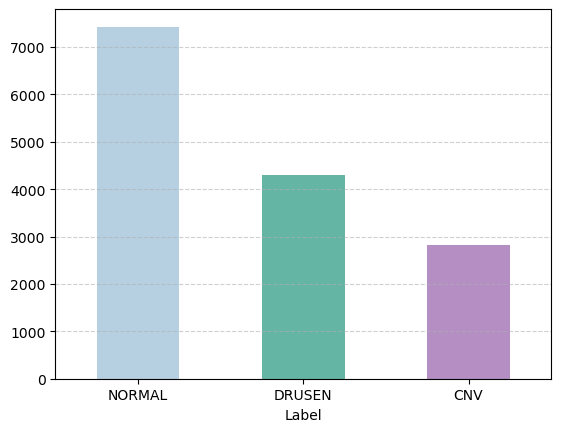

In [83]:
train_df['Label'].value_counts().plot(kind='bar',color = ['#B6D0E2','#64b5a4','#b58ec4'])
plt.grid(linestyle='--', alpha=0.6, axis='y')
plt.xticks(rotation=0)

## Image loading & preprocessing

In [84]:
def crop_from_bottom_with_preprocessing(image):
    
    crop_height = tf.shape(image)[0] - 10  
    original_width = tf.shape(image)[1] -10

    
    cropped_image = tf.image.crop_to_bounding_box(image, 0, 0, crop_height, original_width)
    target_size = (224, 224)
    resized_image = tf.image.resize(cropped_image, target_size)

    return resized_image

In [85]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    height_shift_range=0.1,
    width_shift_range=0.1,
    rotation_range=20,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    #preprocessing_function=crop_from_bottom_with_preprocessing
)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    #preprocessing_function=crop_from_bottom_with_preprocessing
)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    #preprocessing_function=crop_from_bottom_with_preprocessing
)

In [86]:
img_size = (224,224)
batch_size = 16

train_data = train_datagen.flow_from_dataframe(dataframe=train_df, x_col='Path', y_col='Label',
                                               target_size= img_size,
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               shuffle=True
                                              )
val_data = val_datagen.flow_from_dataframe(dataframe=val_df, x_col='Path',y_col='Label',
                                           target_size=img_size,
                                           batch_size=batch_size,
                                           class_mode='categorical'
                                          )
test_data = test_datagen.flow_from_dataframe(dataframe=test_df,x_col='Path',y_col='Label',
                                             target_size=img_size,
                                             batch_size=batch_size,
                                             class_mode='categorical',
                                            )

Found 14548 validated image filenames belonging to 3 classes.
Found 1096 validated image filenames belonging to 3 classes.
Found 1178 validated image filenames belonging to 3 classes.


## View imgaes

In [106]:
def view_images(images,labels):
    plt.figure(figsize=(16,16))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow(images[i])
        plt.title(Labels[np.argmax(labels[i])])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [88]:
import os
Labels = os.listdir('../dataset/NEH_UT_2021RetinalOCTDataset/NEH_UT_2021RetinalOCTDataset/')
Labels

['CNV', 'DRUSEN', 'NORMAL']

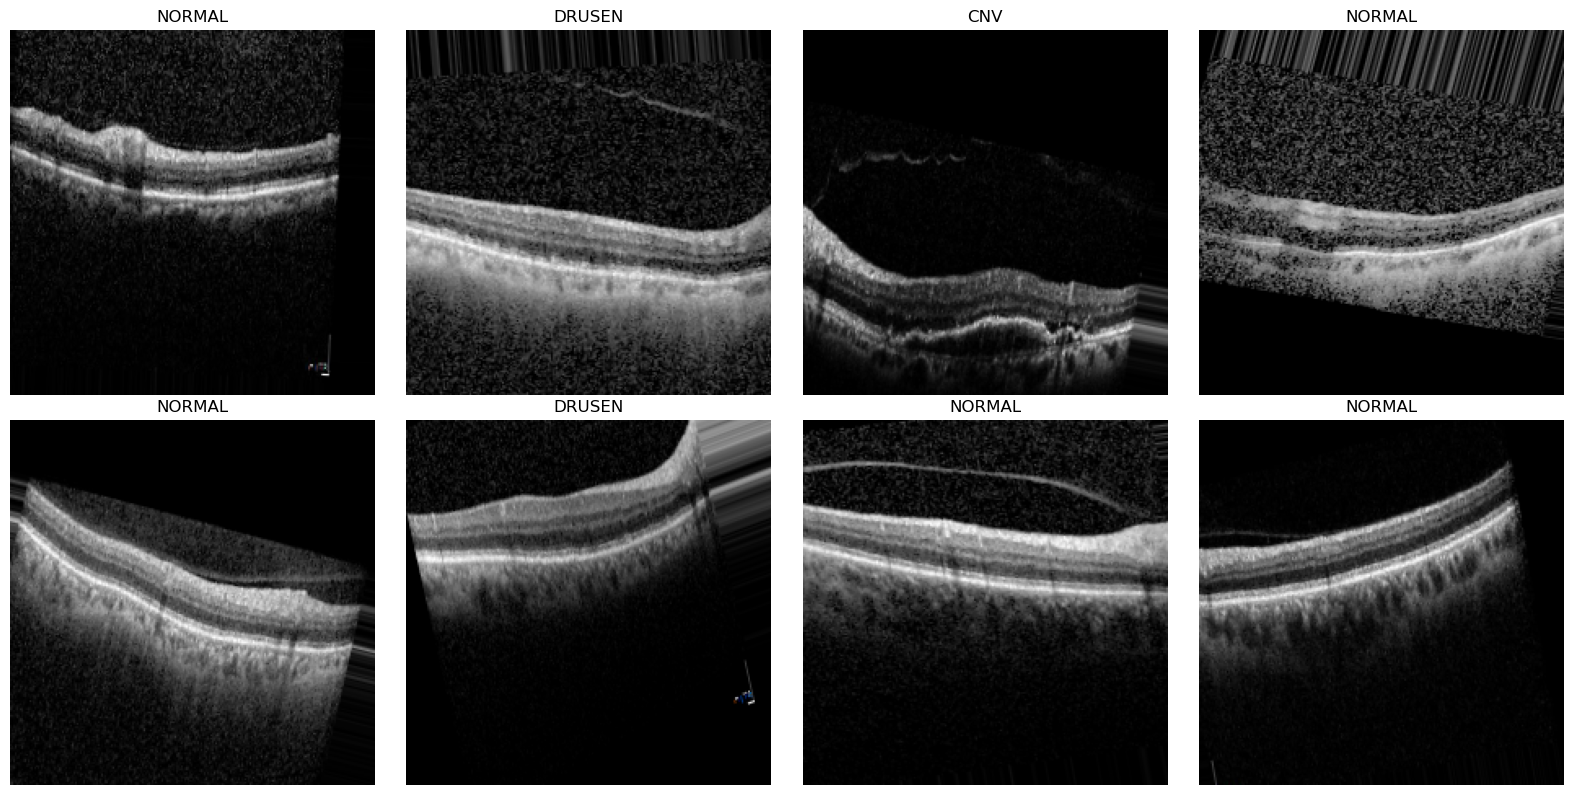

In [89]:
train_images, train_labels = next(train_data)
view_images(train_images, train_labels)

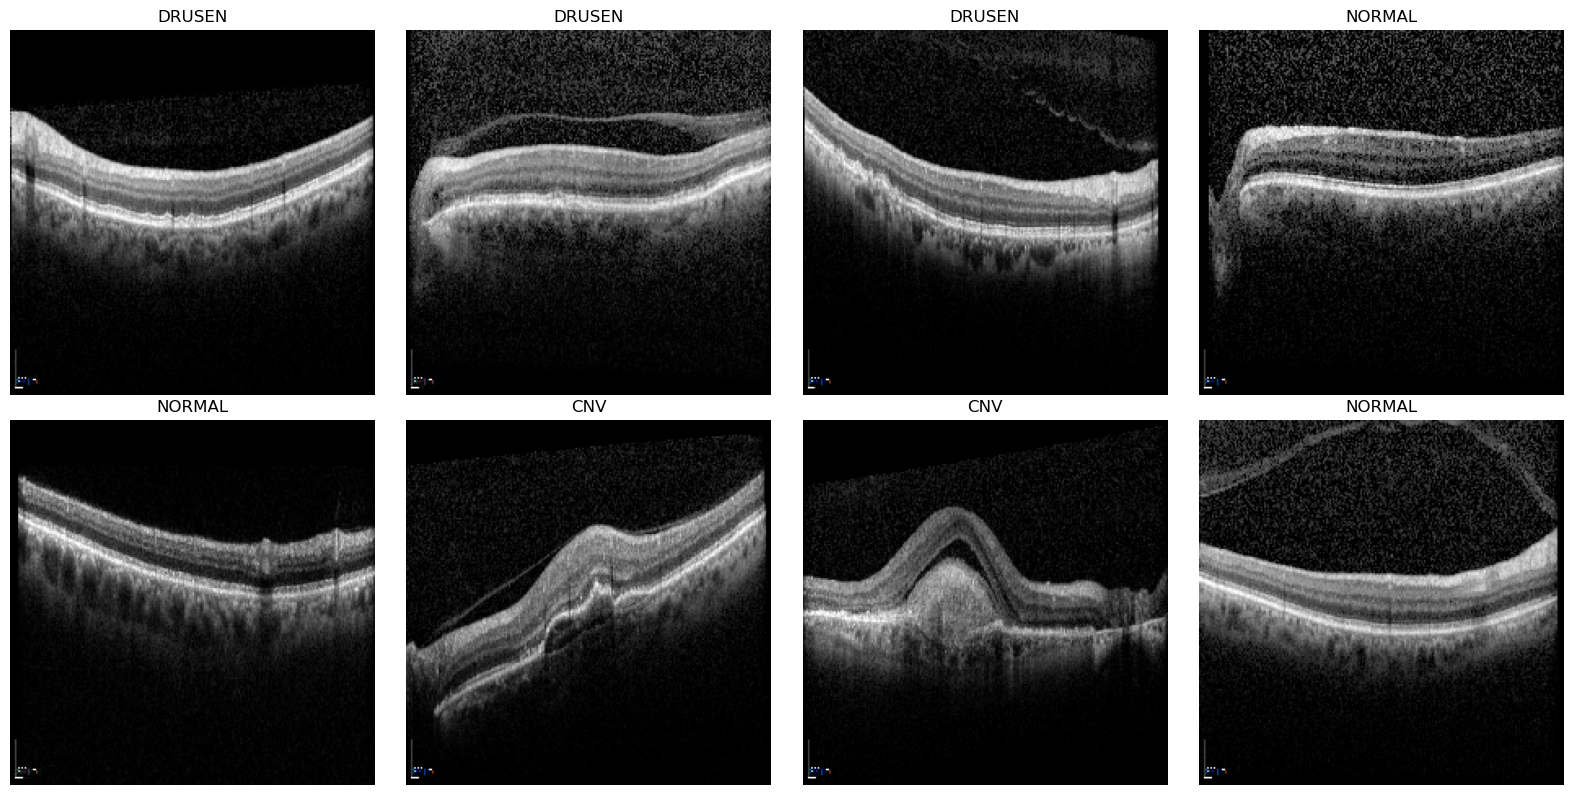

In [90]:
val_images, val_labels = next(val_data)
view_images(val_images, val_labels)

## Preprocess Image

In [150]:
def preprocess_image(image):
    
    # Convert image to numpy
    img = image.numpy()
    
    # If image is float between 0-1, convert to uint8 range
    if img.max() <= 1.0:
        img = (img * 255).astype(np.uint8)
    
    # Ensure image is RGB
    if len(img.shape) != 3 or img.shape[-1] != 3:
        raise ValueError("Input image must be RGB with 3 channels")
    
    # Split RGB channels
    # b, g, r = cv2.split(img)
    
    # # Apply enhanced CLAHE to each channel (stronger contrast enhancement)
    # clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))  # Increased clipLimit for better contrast
    # clahe_r = clahe.apply(r)
    # clahe_g = clahe.apply(g)
    # clahe_b = clahe.apply(b)


    # ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    
    # # Split channels
    # y, cr, cb = cv2.split(ycrcb)
    
    # # Apply CLAHE to the Y (luminance) channel
    # clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    # y_clahe = clahe.apply(y)
    
    # # Merge back the modified Y channel with Cr & Cb
    # ycrcb_clahe = cv2.merge([y_clahe, cr, cb])
    
    # # Convert back to BGR color space
    # image_clahe = cv2.cvtColor(ycrcb_clahe, cv2.COLOR_YCrCb2BGR)

    # Splitting BGR channel
    # b, g, r = cv2.split(image_clahe)
    # # Apply denoising to each channel (tuned for better detail preservation)
    # denoised_r = cv2.fastNlMeansDenoising(
    #     r, h=15, templateWindowSize=7, searchWindowSize=21  # Increased h for stronger denoising
    # )
    # denoised_g = cv2.fastNlMeansDenoising(
    #     g, h=15, templateWindowSize=7, searchWindowSize=21
    # )
    # denoised_b = cv2.fastNlMeansDenoising(
    #     b, h=15, templateWindowSize=7, searchWindowSize=21
    # )


    gaussian = cv2.GaussianBlur(img, (5, 5), 0)
    # # Apply sharpening to enhance cell boundaries (optional for better detail)
    # kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    # sharpened_r = cv2.filter2D(denoised_r, -1, kernel)
    # sharpened_g = cv2.filter2D(denoised_g, -1, kernel)
    # sharpened_b = cv2.filter2D(denoised_b, -1, kernel)


    kernel = np.ones((5, 5), np.uint8)
    opening = cv2.morphologyEx(gaussian, cv2.MORPH_OPEN, kernel)


    # ycrcb = cv2.cvtColor(opening, cv2.COLOR_BGR2YCrCb)
    
    # # Split channels
    # y, cr, cb = cv2.split(ycrcb)
    
    # # Apply CLAHE to the Y (luminance) channel
    # clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    # y_clahe = clahe.apply(y)
    
    # # Merge back the modified Y channel with Cr & Cb
    # ycrcb_clahe = cv2.merge([y_clahe, cr, cb])
    
    # # Convert back to BGR color space
    # image_clahe = cv2.cvtColor(ycrcb_clahe, cv2.COLOR_YCrCb2BGR)


    sharpen_kernel = np.array([[-1, -1, -1], 
                               [-1,  9, -1], 
                               [-1, -1, -1]])

    # Apply the sharpening kernel
    sharpened_image = cv2.filter2D(opening, -1, sharpen_kernel)

    
    # Merge channels back to RGB
    #processed_img = cv2.merge([denoised_b, denoised_g, denoised_r])
    #canny = cv2.Canny(processed_img, 200, 200)
    
    # Clip values to ensure they stay in uint8 range (0-255)
    processed_img = np.clip(sharpened_image, 0, 255).astype(np.uint8)
    
    # Convert back to float32 and normalize to [0, 1]
    processed_img = tf.convert_to_tensor(processed_img, dtype=tf.float32)
    processed_img = processed_img / 255.0
    
    return processed_img

In [151]:
def tf_preprocess(img):
    return tf.py_function(
        preprocess_image,
        [img],
        tf.float32
    )

In [152]:
def process_dataset(train_data):
    
    # Convert to tf.data.Dataset if it isn't already
    if not isinstance(train_data, tf.data.Dataset):
        # Get the images and labels from generator
        
        images, labels = next(train_data)
        dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    else:
        dataset = train_data
    
    # Apply preprocessing to all images
    processed_dataset = dataset.map(
        lambda x, y: (tf_preprocess(x), y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    processed_dataset = processed_dataset.batch(16)
    return processed_dataset

In [154]:
processed_train_data = process_dataset(train_data)
processed_train_data = processed_train_data.cache()
processed_train_data = processed_train_data.prefetch(tf.data.AUTOTUNE)

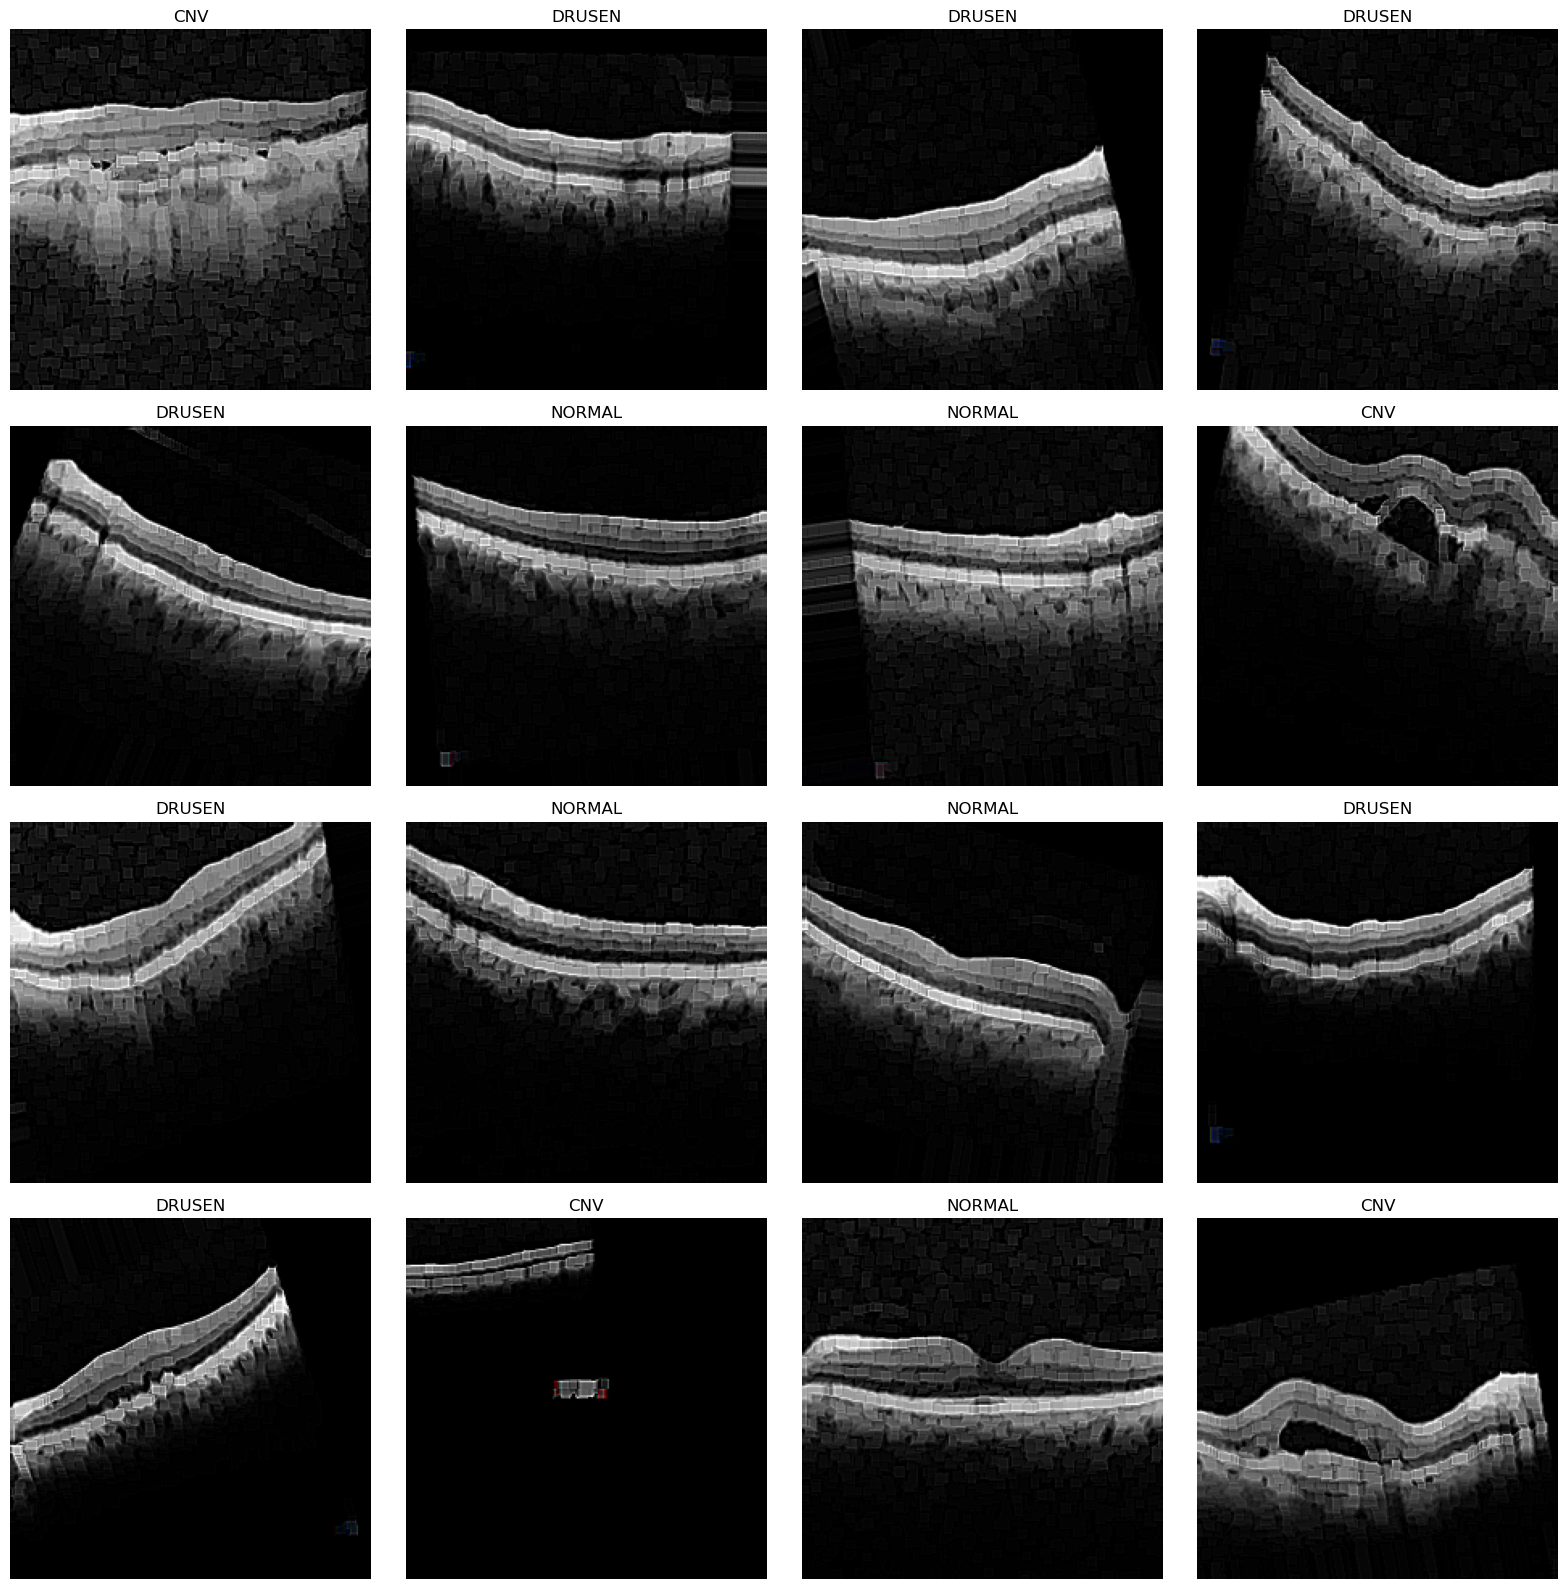

In [155]:
processed_image, processed_label = next(iter(processed_train_data))
view_images(processed_image, processed_label)

In [156]:
processed_val_data = process_dataset(val_data)
processed_val_data = processed_val_data.cache()
processed_val_data = processed_val_data.prefetch(tf.data.AUTOTUNE)

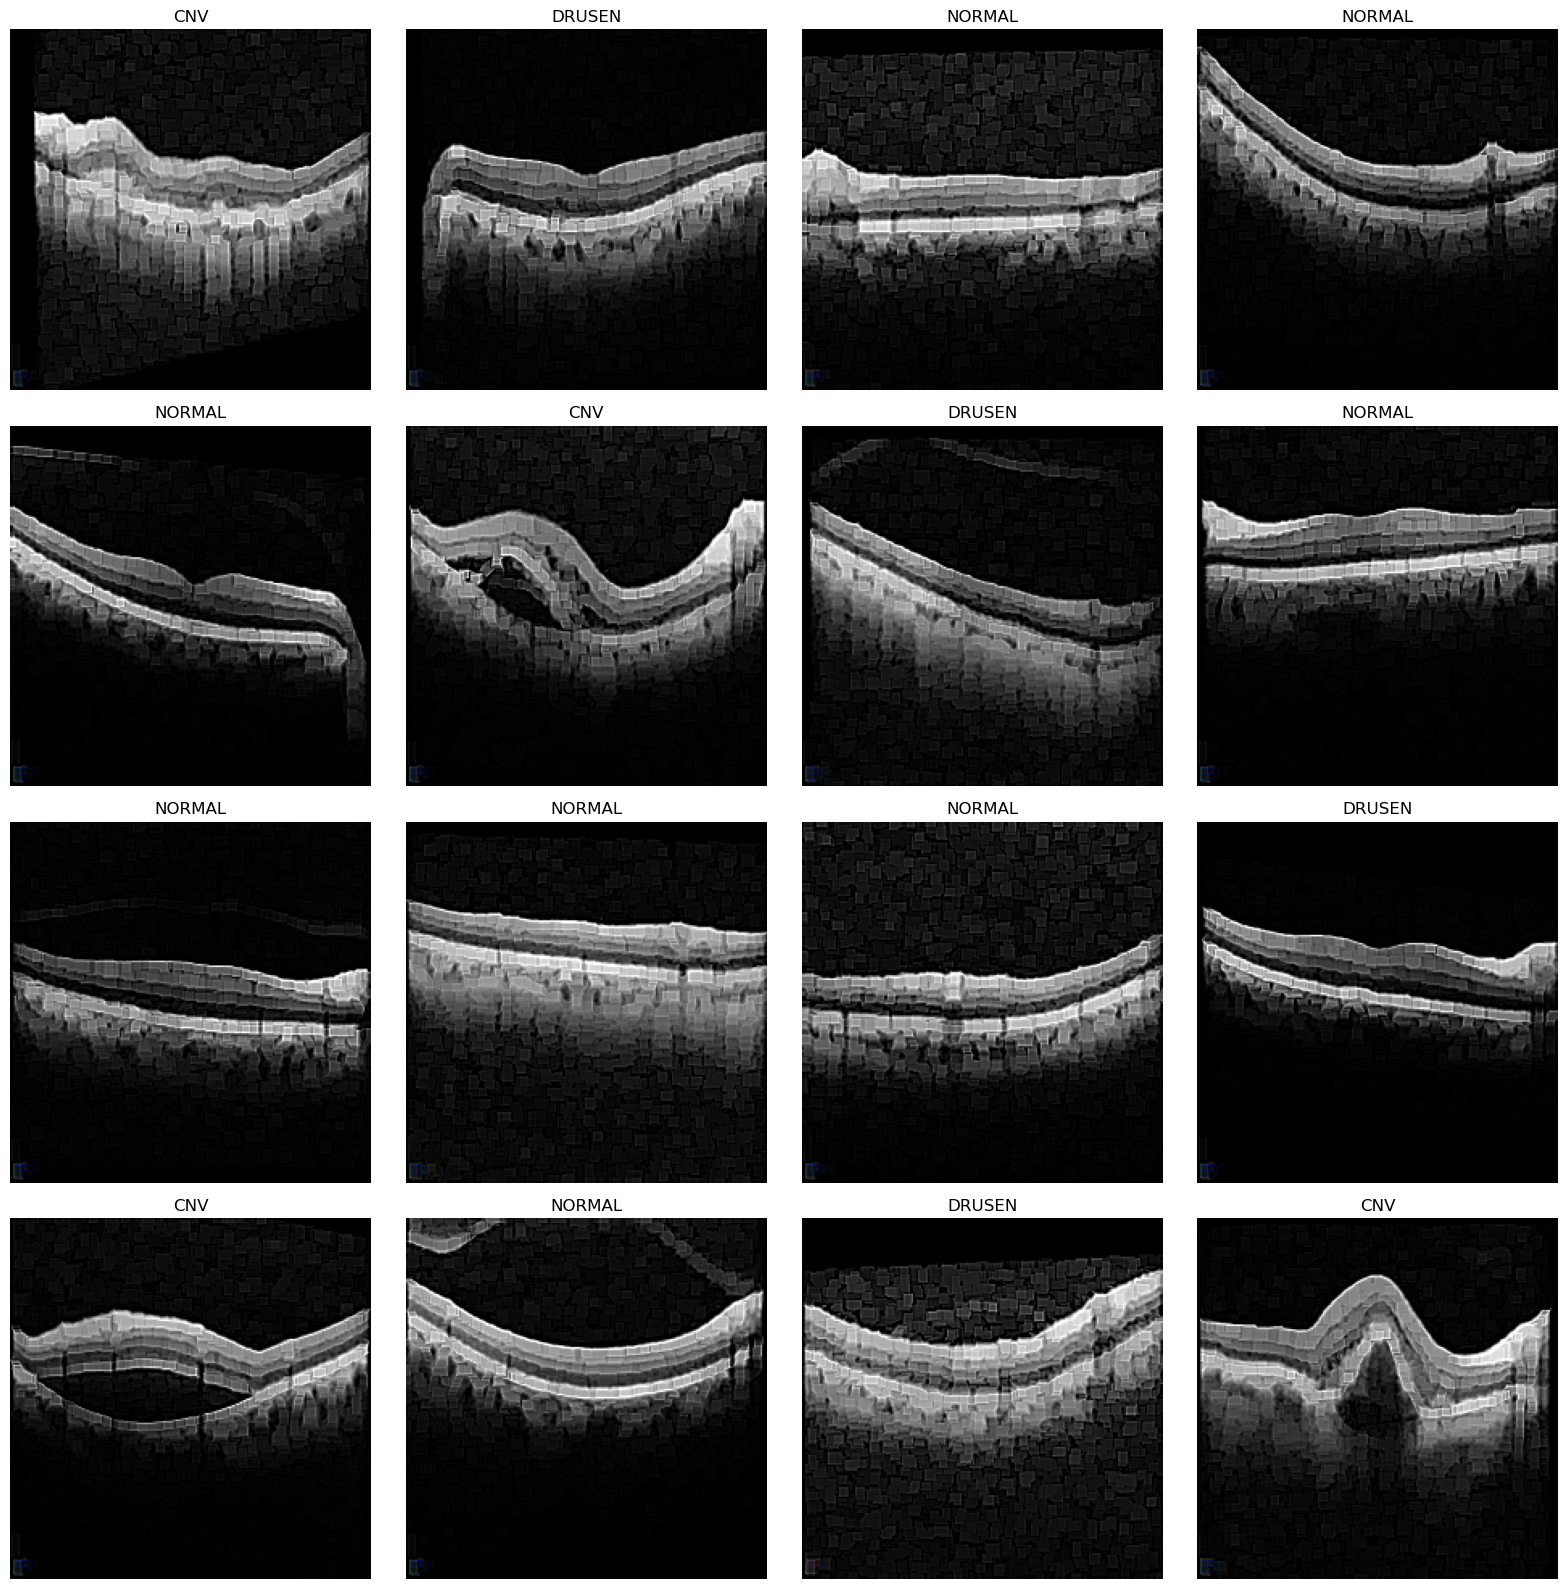

In [157]:
val_images_processed,val_labels_processed = next(iter(processed_val_data))
view_images(val_images_processed,val_labels_processed)

In [148]:
processed_label[:2]

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [0., 1., 0.]], dtype=float32)>

In [149]:
print(processed_train_data[0].shape)

TypeError: 'BatchDataset' object is not subscriptable

## Training

In [158]:
from tensorflow.keras.applications import VGG16
vgg_base = VGG16(weights = 'imagenet', include_top = False, input_shape = (224,224,3))
for layer in vgg_base.layers:
    layer.trainable = False
vgg_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [159]:
vgg_model = Sequential([
    Input(shape = (224,224,3)),
    vgg_base,
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(256,activation='relu',kernel_regularizer=regularizers.l2(0.0001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(3,activation='softmax')
])
vgg_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 batch_normalization_14 (Bat  (None, 7, 7, 512)        2048      
 chNormalization)                                                
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_14 (Dense)            (None, 256)               131328    
                                                                 
 batch_normalization_15 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                      

In [160]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    mode='max',
    restore_best_weights=True
)

lr_reduce = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=1,
    factor=.5,
    min_lr=1e-6
)

In [161]:
vgg_model.compile(
    loss = tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001,beta_1=0.95),
    metrics=['accuracy']
)

In [162]:
vgg_history  = vgg_model.fit(processed_train_data, epochs=50, validation_data=processed_val_data,callbacks=[early_stopping], verbose=2)

Epoch 1/50
1/1 - 3s - loss: 2.2048 - accuracy: 0.3125 - val_loss: 1.1976 - val_accuracy: 0.2500 - 3s/epoch - 3s/step
Epoch 2/50
1/1 - 2s - loss: 2.2301 - accuracy: 0.3750 - val_loss: 1.1977 - val_accuracy: 0.2500 - 2s/epoch - 2s/step
Epoch 3/50
1/1 - 2s - loss: 3.2129 - accuracy: 0.1875 - val_loss: 1.1977 - val_accuracy: 0.2500 - 2s/epoch - 2s/step
Epoch 4/50
1/1 - 2s - loss: 2.5495 - accuracy: 0.1875 - val_loss: 1.1978 - val_accuracy: 0.2500 - 2s/epoch - 2s/step
Epoch 5/50
1/1 - 2s - loss: 2.3785 - accuracy: 0.5000 - val_loss: 1.1978 - val_accuracy: 0.2500 - 2s/epoch - 2s/step
Epoch 6/50
1/1 - 2s - loss: 2.1945 - accuracy: 0.3125 - val_loss: 1.1979 - val_accuracy: 0.2500 - 2s/epoch - 2s/step


In [36]:
vgg_model.evaluate(test_data)

74/74 [==============================] - 10s 128ms/step - loss: 1.3784 - accuracy: 0.3905


[1.378426432609558, 0.39049234986305237]

## DenseNet121

In [48]:
from tensorflow.keras.applications import DenseNet121
input_shape = (224, 224, 3)

# Load DenseNet121 base model (pre-trained on ImageNet)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model
base_model.trainable = False

# Build the model using Sequential API
model = Sequential([
    base_model,  # Add the pre-trained DenseNet121
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # Assuming 10 classes
])

# Compile the model
model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.95),
    metrics=['accuracy']
)

# Print model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d_4   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 512)               524800    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 7,563,843
Trainable params: 526,339
Non-trainable params: 7,037,504
______________________________________

In [49]:
dens_history  = model.fit(processed_train_data, validation_data=processed_val_data, epochs=50, callbacks=[early_stopping,lr_reduce],verbose=2)

Epoch 1/50
1/1 - 7s - loss: 1.7705 - accuracy: 0.4375 - val_loss: 1.3889 - val_accuracy: 0.1875 - lr: 1.0000e-04 - 7s/epoch - 7s/step
Epoch 2/50
1/1 - 0s - loss: 1.3455 - accuracy: 0.4375 - val_loss: 1.2293 - val_accuracy: 0.2500 - lr: 1.0000e-04 - 206ms/epoch - 206ms/step
Epoch 3/50
1/1 - 0s - loss: 1.4671 - accuracy: 0.3750 - val_loss: 1.1371 - val_accuracy: 0.2500 - lr: 1.0000e-04 - 111ms/epoch - 111ms/step
Epoch 4/50
1/1 - 0s - loss: 1.2635 - accuracy: 0.3750 - val_loss: 1.1035 - val_accuracy: 0.3750 - lr: 5.0000e-05 - 147ms/epoch - 147ms/step
Epoch 5/50
1/1 - 0s - loss: 1.3236 - accuracy: 0.3125 - val_loss: 1.0789 - val_accuracy: 0.5000 - lr: 5.0000e-05 - 147ms/epoch - 147ms/step
Epoch 6/50
1/1 - 0s - loss: 1.3826 - accuracy: 0.3125 - val_loss: 1.0603 - val_accuracy: 0.5625 - lr: 5.0000e-05 - 153ms/epoch - 153ms/step
Epoch 7/50
1/1 - 0s - loss: 1.3843 - accuracy: 0.3750 - val_loss: 1.0458 - val_accuracy: 0.5000 - lr: 5.0000e-05 - 102ms/epoch - 102ms/step
Epoch 8/50
1/1 - 0s - loss

## ConvNextBase

In [24]:
from tensorflow.keras.applications import ConvNeXtBase
conv_base = ConvNeXtBase(weights='imagenet', include_top = False, input_shape = (224,224,3))
for layer in conv_base.layers:
    layer.trainable = False
conv_base.summary()

Model: "convnext_base"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 convnext_base_prestem_normaliz  (None, 224, 224, 3)  0          ['input_1[0][0]']                
 ation (Normalization)                                                                            
                                                                                                  
 convnext_base_stem (Sequential  (None, 56, 56, 128)  6528       ['convnext_base_prestem_normaliza
 )                                                               tion[0][0]']         

In [25]:
conv_model = Sequential([
    Input(shape = (224,224,3)),
    conv_base,
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(3, activation='softmax')
])
conv_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_base (Functional)  (None, 7, 7, 1024)        87566464  
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 1024)       4096      
 ormalization)                                                   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 87,833,731
Trainable params: 265,219
Non-t

In [26]:
conv_model.compile(loss=tf.keras.losses.categorical_crossentropy,
                    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6, beta_1=0.99),
                    metrics=['accuracy']
                   )

In [27]:
conv_history = conv_model.fit(processed_train_data, epochs=50, validation_data=processed_val_data, verbose=2)

Epoch 1/50
1/1 - 22s - loss: 1.0639 - accuracy: 0.4375 - val_loss: 1.1038 - val_accuracy: 0.6250 - 22s/epoch - 22s/step
Epoch 2/50
1/1 - 1s - loss: 1.0634 - accuracy: 0.4375 - val_loss: 1.0952 - val_accuracy: 0.6250 - 679ms/epoch - 679ms/step
Epoch 3/50
1/1 - 1s - loss: 1.0629 - accuracy: 0.4375 - val_loss: 1.0894 - val_accuracy: 0.6250 - 659ms/epoch - 659ms/step
Epoch 4/50
1/1 - 1s - loss: 1.0624 - accuracy: 0.4375 - val_loss: 1.0846 - val_accuracy: 0.6250 - 660ms/epoch - 660ms/step
Epoch 5/50
1/1 - 1s - loss: 1.0619 - accuracy: 0.4375 - val_loss: 1.0811 - val_accuracy: 0.6250 - 654ms/epoch - 654ms/step
Epoch 6/50
1/1 - 1s - loss: 1.0614 - accuracy: 0.4375 - val_loss: 1.0789 - val_accuracy: 0.6250 - 647ms/epoch - 647ms/step
Epoch 7/50
1/1 - 1s - loss: 1.0609 - accuracy: 0.4375 - val_loss: 1.0773 - val_accuracy: 0.6250 - 661ms/epoch - 661ms/step
Epoch 8/50
1/1 - 1s - loss: 1.0604 - accuracy: 0.4375 - val_loss: 1.0761 - val_accuracy: 0.6250 - 657ms/epoch - 657ms/step
Epoch 9/50
1/1 - 1s